https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach

In [1]:
import pandas as pd
import numpy as np
import shap
shap.initjs()

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



In [7]:
from sklearn.datasets import load_wine
wine = load_wine()
X, Y = wine.data, wine.target

print("Total Data Size : ", X.shape, Y.shape)


Total Data Size :  (178, 13) (178,)


In [10]:
X

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

In [8]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.85, test_size=0.15, stratify=Y, random_state=123, shuffle=True)

print("Train/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)



Train/Test Sizes :  (151, 13) (27, 13) (151,) (27,)


In [11]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, Y_train)

print()
print("Test  Accuracy : ", log_reg.score(X_test, Y_test))
print("Train Accuracy : ", log_reg.score(X_train, Y_train))


Test  Accuracy :  1.0
Train Accuracy :  0.9867549668874173


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


We'll start by creating LinearExplainer which is commonly used for the linear model. It has the below-mentioned arguments:

- model - It accepts the model which we trained with train data. It can even accept tuple of (coef, intercept) instead.
- data - It accepts data based on which it'll generate SHAP values. We can provide a numpy array, pandas dataframe, scipy sparse matrix, etc. It can also accept tuple with (mean, cov).
- feature_perturbation - It accepts one of the below strings.
    - interventional - It lets us compute SHAP values discarding the relationship between features.
    - correlation_dependent - It lets us compute SHAP values considering relationship between features.
- nsamples - It accepts integer specifying a number of samples to use for calculating transformation matrix used to account for feature correlation when feature_perturbation is set to correlation_dependent.

In [28]:
log_reg_explainer= shap.LinearExplainer(log_reg, X_train)

Below we are generating shap values for the 0th sample of test data. As this is a multi-class classification task the base value will be three different values which are the same as a number of classes in data. The shape values generated by the explainer will also be a list of three arrays which will have shape values for each class. We are again adding shap values for each class to the expected (base) value of each class which will generate three different values, unlike the regression task which only generates one. We then take an index of value which is highest to be a class prediction.

In [29]:
log_reg.predict(X_test[0].reshape(1,-1))

array([1])

In [31]:
sample_idx = 0

shap_vals = log_reg_explainer.shap_values(X_test[sample_idx])

val1 = log_reg_explainer.expected_value[0] + shap_vals[0].sum()
val2 = log_reg_explainer.expected_value[1] + shap_vals[1].sum()
val3 = log_reg_explainer.expected_value[2] + shap_vals[2].sum()

print("Expected/Base Values : ", log_reg_explainer.expected_value)
print()
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("\n")
print("Prediction From Model                            : ", \
                      wine.target_names[log_reg.predict(X_test[sample_idx].reshape(1, -1))[0]])
print("Prediction From Adding SHAP Values to Base Value : ", wine.target_names[np.argmax([val1, val2, val3])])

Expected/Base Values :  [ 1.12479353 -0.33087671 -0.79391682]

Shap Values for Sample 0 :  [array([ 0.33066209, -0.36187808,  0.15146323, -1.13463586,  0.31350118,
       -0.00469265,  0.24334187,  0.00437098,  0.0693318 , -0.30049464,
        0.01077203,  0.38155953, -3.69391739]), array([-0.55858533,  0.7184114 , -0.16788937,  0.76498074,  0.10605369,
        0.04891945,  0.06956626,  0.01761637, -0.25700467,  1.81759035,
       -0.04069657,  0.00729569,  3.32573273]), array([ 0.22792323, -0.35653331,  0.01642615,  0.36965512, -0.41955486,
       -0.0442268 , -0.31290813, -0.02198735,  0.18767286, -1.5170957 ,
        0.02992453, -0.38885523,  0.36818466])]


Prediction From Model                            :  class_1
Prediction From Adding SHAP Values to Base Value :  class_1


Below we have created another LinearExplainer by giving model and train data as input. We have also set feature_perturbation to correlation_dependent. This will create an explainer which takes into account the relationship between features.

In [32]:
#log_reg_explainer2 = shap.LinearExplainer(log_reg, X_train, feature_perturbation="correlation_dependent")

### Bar Plot
The bar plot shows the shap values of each feature for a particular sample of data. Below is a list of important parameters of the bar_plot() method of shap.

Below we have plotted 3 bar plot of shap values of the 0th test sample. since, its a multi-class classification problem hence the shap_values() method will return shap values for each class of data. We have plotted shap value for all class types to show how different feature's shap values contribute to each class type differently.

- shap_values - It accepts an array of shap values for an individual sample of data.
- feature_names - It accepts a list of feature names.
- max_display - It accepts integer specifying how many features to display in a bar chart.

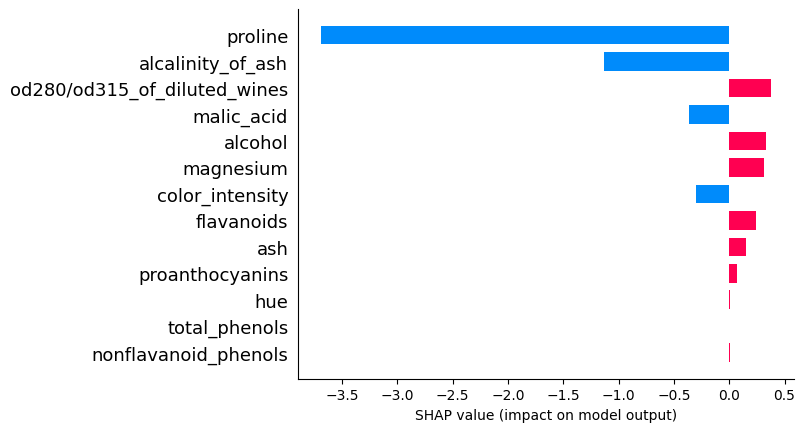

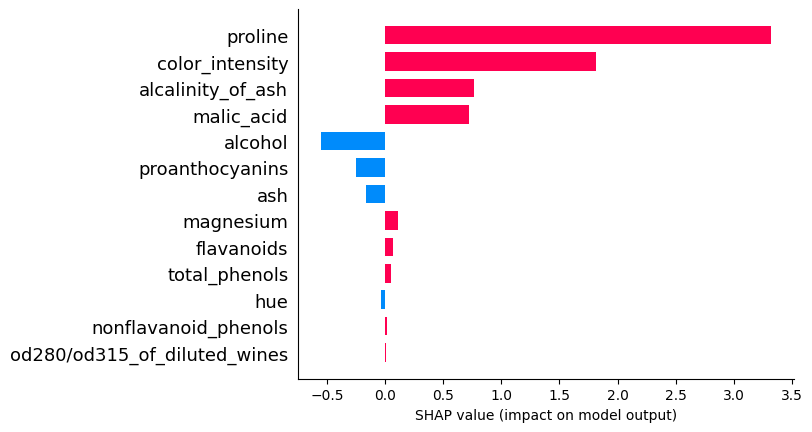

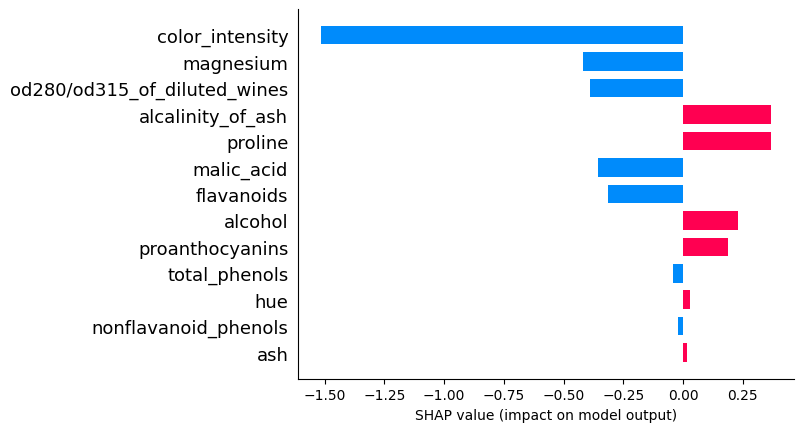

In [40]:
shap.bar_plot(log_reg_explainer.shap_values(X_test[0])[0],feature_names=wine.feature_names,max_display=len(wine.feature_names))
shap.bar_plot(log_reg_explainer.shap_values(X_test[0])[1],feature_names=wine.feature_names,max_display=len(wine.feature_names))
shap.bar_plot(log_reg_explainer.shap_values(X_test[0])[2],feature_names=wine.feature_names,max_display=len(wine.feature_names))

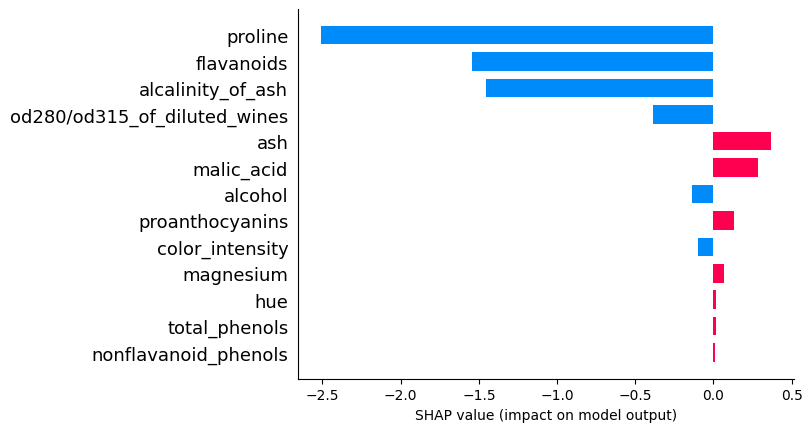

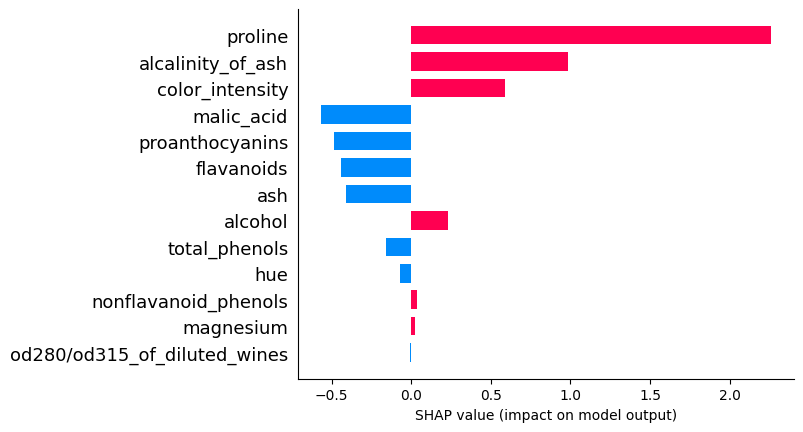

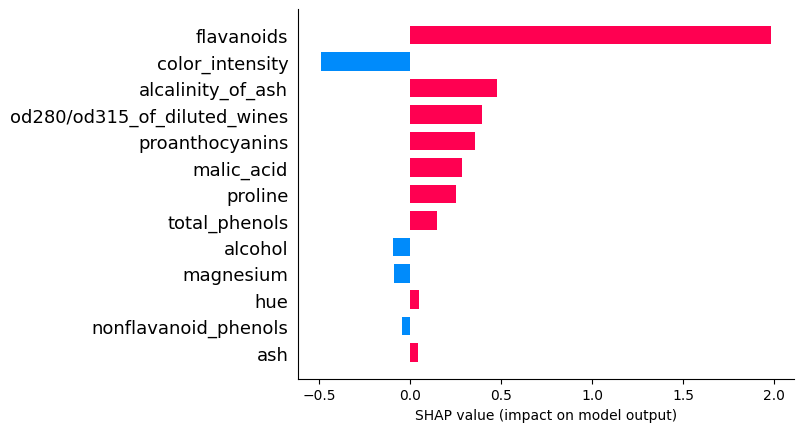

In [43]:
shap.bar_plot(log_reg_explainer.shap_values(X_test[1])[0],feature_names=wine.feature_names,max_display=len(wine.feature_names))
shap.bar_plot(log_reg_explainer.shap_values(X_test[1])[1],feature_names=wine.feature_names,max_display=len(wine.feature_names))
shap.bar_plot(log_reg_explainer.shap_values(X_test[1])[2],feature_names=wine.feature_names,max_display=len(wine.feature_names))

Below we have generated another bar plot of shap values for our second explainer which was based on the relationship between features.

### Waterfall Plot
The second chart that we'll explain is a waterfall chart which shows how shap values of individual features are added to the base value in order to generate a final prediction. Below is a list of important parameters of the waterfall_plot() method.

- shap_values - It accepts shap values object for an individual sample of data.
- max_display -It accepts integer specifying how many features to display in a bar chart.

In [51]:
#below we have generated shap values for only one test sample
shap_values = log_reg_explainer(X_test[:1])
shap_values.feature_names =wine.feature_names



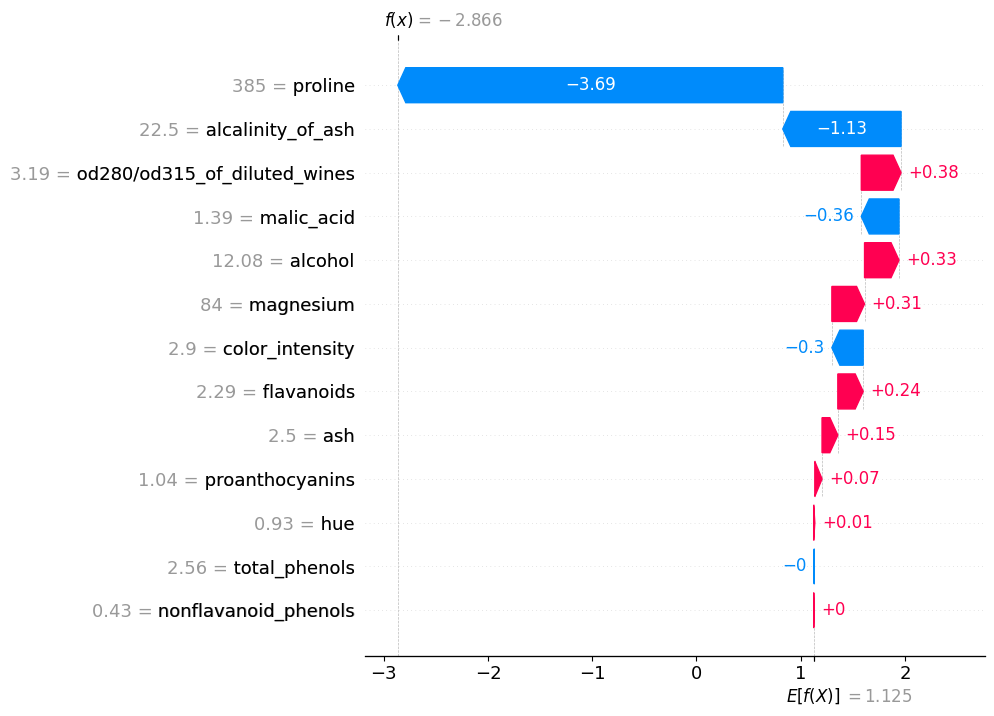

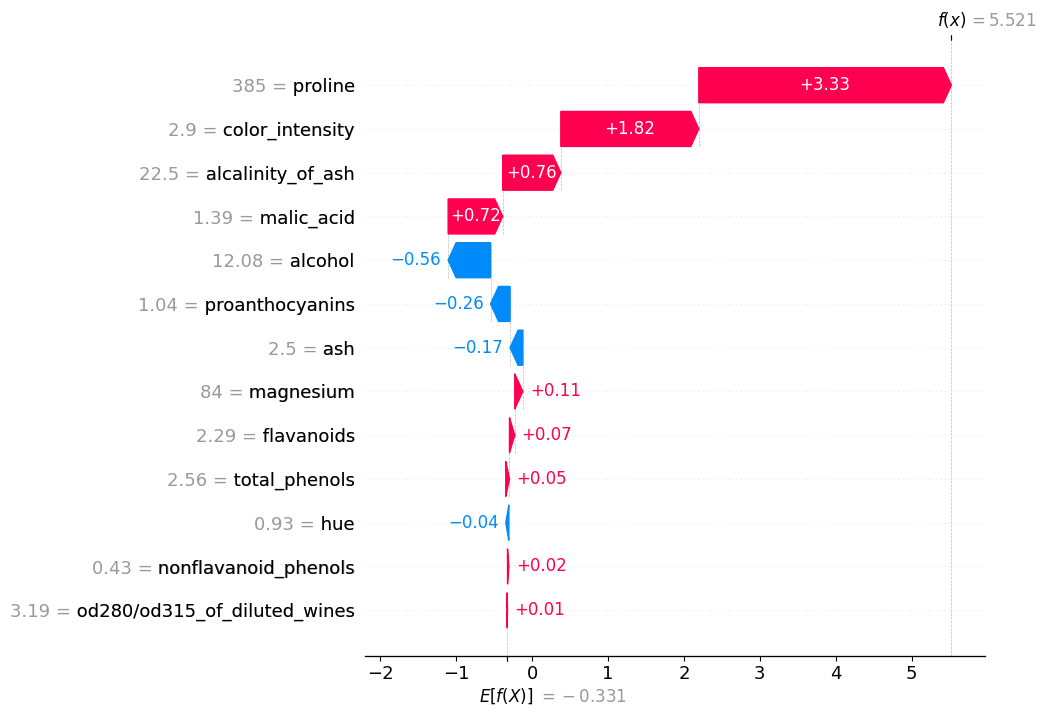

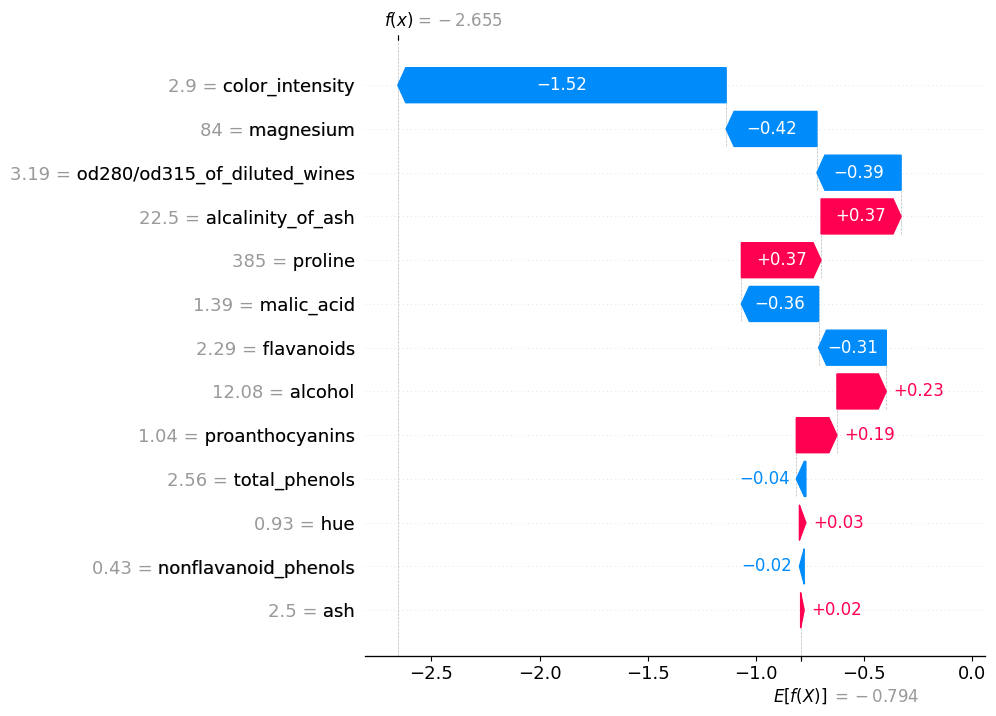

In [52]:
shap.waterfall_plot(shap_values[0][:, 0], max_display=len(wine.feature_names))

shap.waterfall_plot(shap_values[0][:, 1], max_display=len(wine.feature_names))

shap.waterfall_plot(shap_values[0][:, 2], max_display=len(wine.feature_names))

__In the below code we have generated shap values for the entire test dataset__

In [53]:
shap_values = log_reg_explainer(X_test)
shap_values.feature_names =wine.feature_names


__shap values 0 have 3 columns and each column represent the shap values for each class of sample 0__

In [55]:
shap_values[0]

.values =
array([[ 0.33066209, -0.55858533,  0.22792323],
       [-0.36187808,  0.7184114 , -0.35653331],
       [ 0.15146323, -0.16788937,  0.01642615],
       [-1.13463586,  0.76498074,  0.36965512],
       [ 0.31350118,  0.10605369, -0.41955486],
       [-0.00469265,  0.04891945, -0.0442268 ],
       [ 0.24334187,  0.06956626, -0.31290813],
       [ 0.00437098,  0.01761637, -0.02198735],
       [ 0.0693318 , -0.25700467,  0.18767286],
       [-0.30049464,  1.81759035, -1.5170957 ],
       [ 0.01077203, -0.04069657,  0.02992453],
       [ 0.38155953,  0.00729569, -0.38885523],
       [-3.69391739,  3.32573273,  0.36818466]])

.base_values =
array([ 1.12479353, -0.33087671, -0.79391682])

.data =
array([ 12.08,   1.39,   2.5 ,  22.5 ,  84.  ,   2.56,   2.29,   0.43,
         1.04,   2.9 ,   0.93,   3.19, 385.  ])

In [56]:
shap_values[0][:,0]

.values =
array([ 0.33066209, -0.36187808,  0.15146323, -1.13463586,  0.31350118,
       -0.00469265,  0.24334187,  0.00437098,  0.0693318 , -0.30049464,
        0.01077203,  0.38155953, -3.69391739])

.base_values =
1.124793525154192

.data =
array([ 12.08,   1.39,   2.5 ,  22.5 ,  84.  ,   2.56,   2.29,   0.43,
         1.04,   2.9 ,   0.93,   3.19, 385.  ])

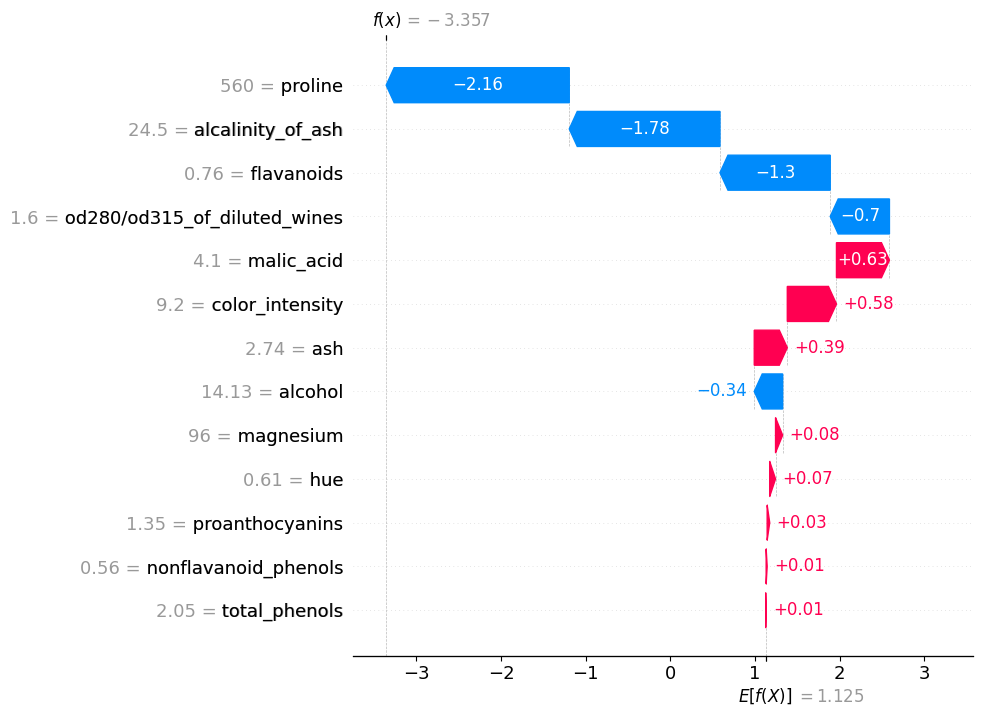

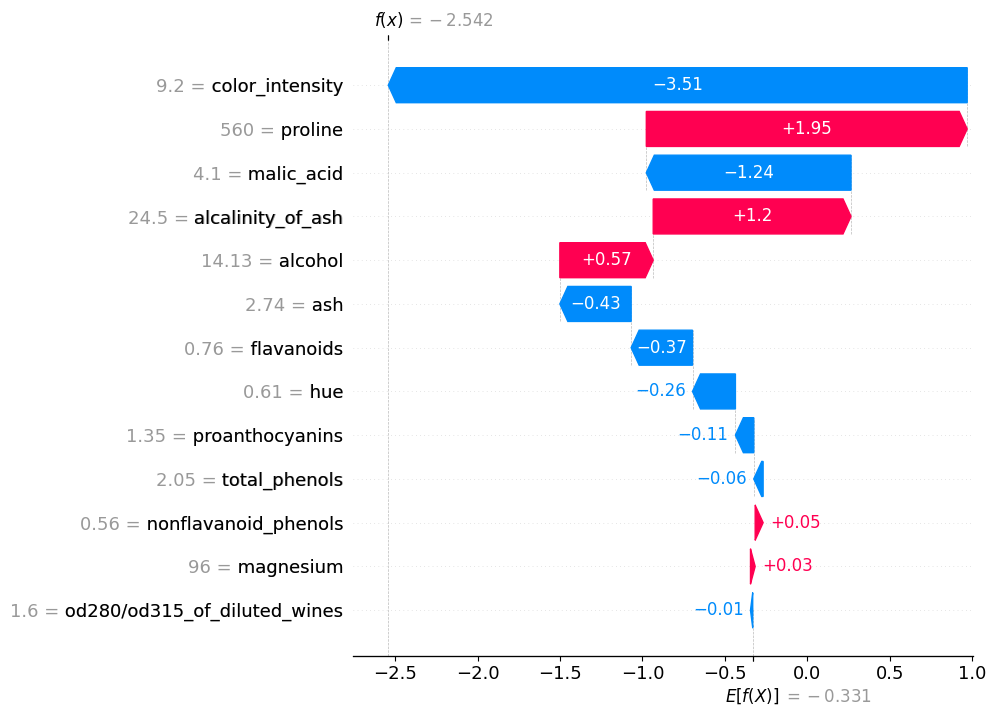

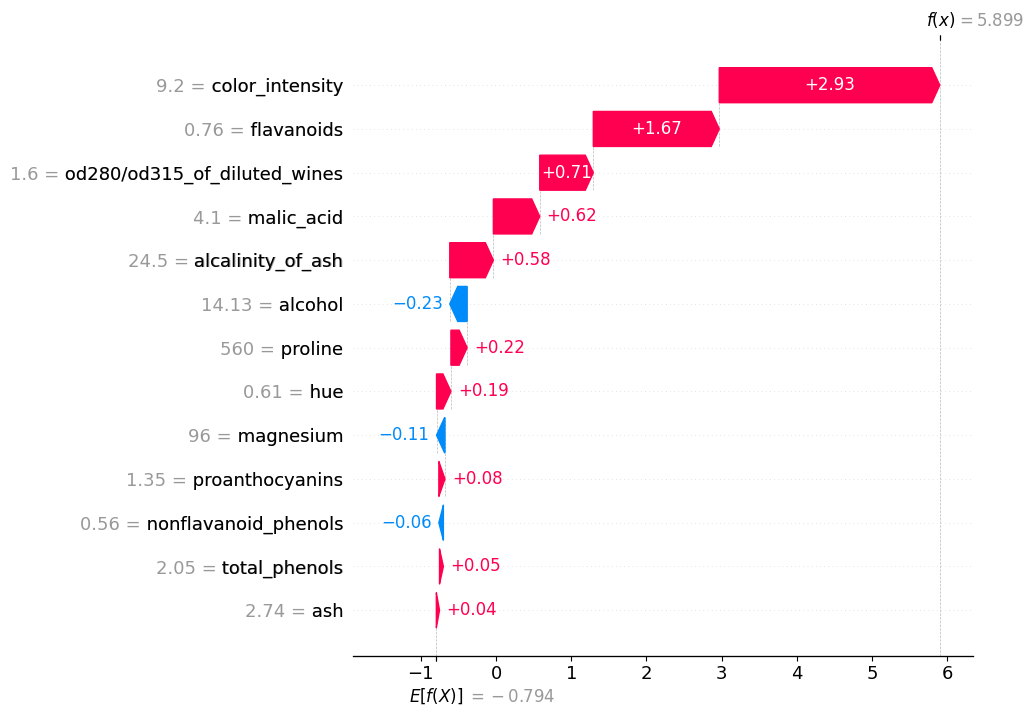

In [50]:
shap.waterfall_plot(shap_values[11][:, 0], max_display=len(wine.feature_names))

shap.waterfall_plot(shap_values[11][:, 1], max_display=len(wine.feature_names))

shap.waterfall_plot(shap_values[11][:, 2], max_display=len(wine.feature_names))

### __Decision Plot__
The decision plot shows like the waterfall chart show the decision path followed by applying the shap values of individual features one by one to the expected value in order to generate predicted value as a line chart.

Below we have generated a decision plot for 0th sample of test data. We have also highlighted the actual prediction. Please make a note that we have used the multioutput_decision_plot() method for generating a plot for this case instead of decision_plot().

- expected_value - It accepts base value on which shap values will be added. The explainer object has a property named expected_value which needs to be passed to this parameter.
- shap_values - It accepts an array of shap values for an individual sample of data.
- feature_names - It accepts a list of feature names.
- feature_order - It accepts a list of below values as input and orders feature accordingly.
    - importance - Default Value. Orders feature according to the importance
    - hcluse - Hierarchical Clustering
    - none
    - list of array of indices
- highlight - It accepts a list of indexes specifying which samples to highlight from the list of samples.
- link - It accepts string specifying type of transformation used for the x-axis. It accepts one of the below values.
    - identity
    - logit
- plot_color - It accepts matplotlib colormap to use to the color plot.
- color_bar - It accepts boolean value specifying whether to display color bar or not.

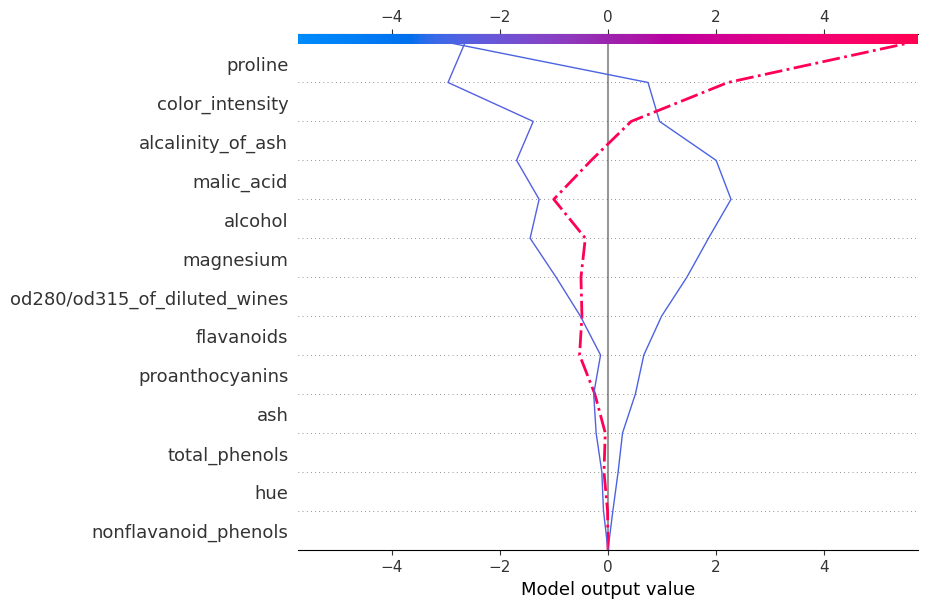

In [57]:
shap.multioutput_decision_plot(log_reg_explainer.expected_value.tolist(),
                               log_reg_explainer.shap_values(X_test),
                               row_index=0,
                               feature_names=wine.feature_names,
                               highlight = [1]
                               )

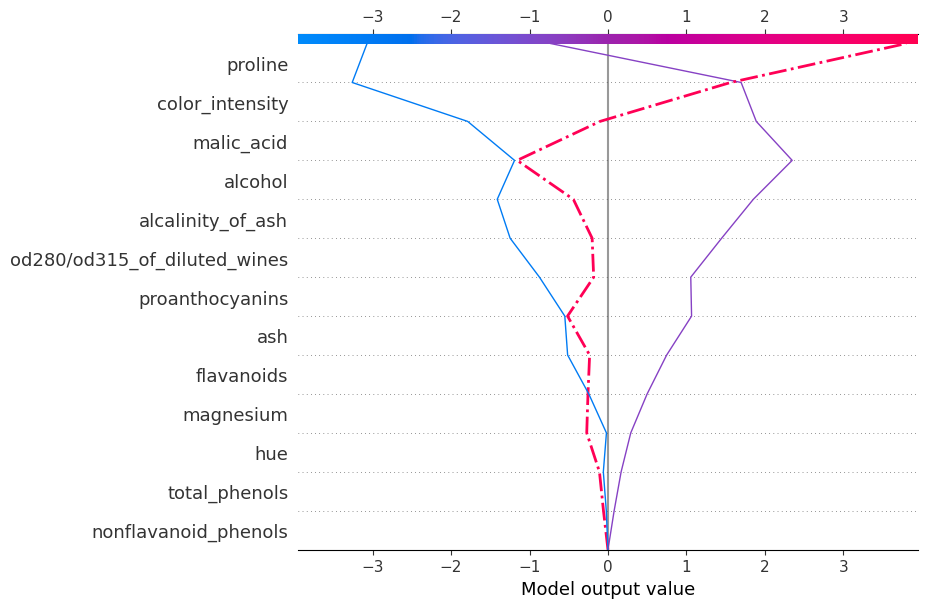

In [58]:
shap.multioutput_decision_plot(log_reg_explainer.expected_value.tolist(),
                               log_reg_explainer.shap_values(X_test),
                               row_index=2,
                               feature_names=wine.feature_names,
                               highlight = [1]
                               )

### Dependence Plot
The dependence plot shows the relation between actual feature value and shap values for a particular feature of the dataset. We can generate a dependence plot using the dependence_plot() method. Below is a list of important parameters of the dependence_plot() method.

SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.

We can use the dependence_plot method for ploting the effect of a feature on the prediction with or without the influence of another feature. If you don't give any interaction_index parameter, SHAP will decide by itself and propose automatically an interaction feature for you.

- ind - It accepts either integer specifying the index of feature from data or string specifying the name of the feature. For future names given as a string, we need to provide feature names as a list to parameter feature_names.
- shap_values - It accepts an array of shap values for an individual sample of data.
- features - It accepts dataset which was used to generate shap values given to the shap_values parameter.
- feature_names - It accepts a list of feature names.

__Below we have generated a dependence plot for the proline feature. We have generated 3 dependence plots using 3 different shap values based on a different classes.__

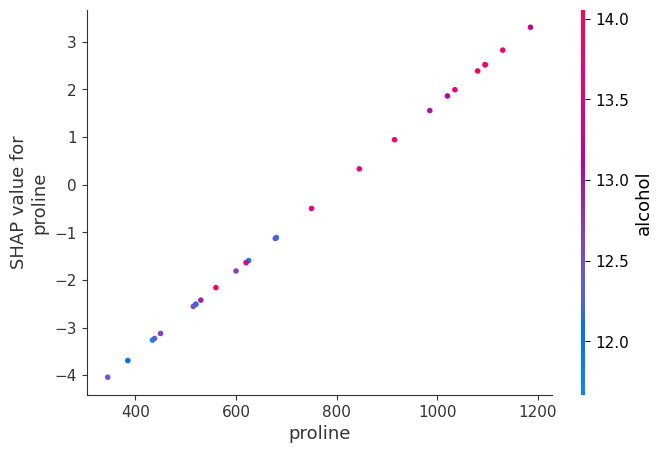

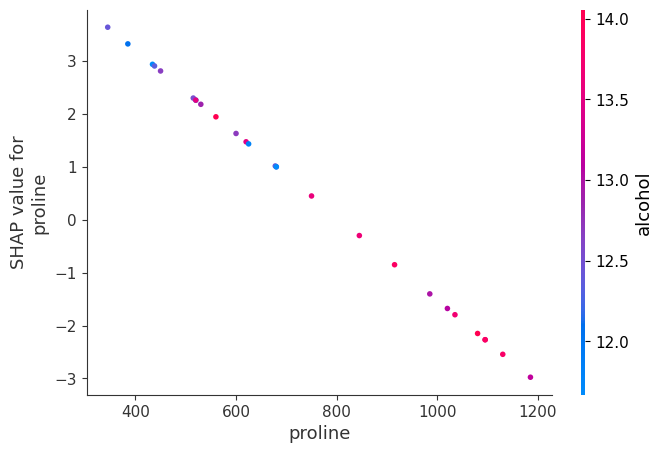

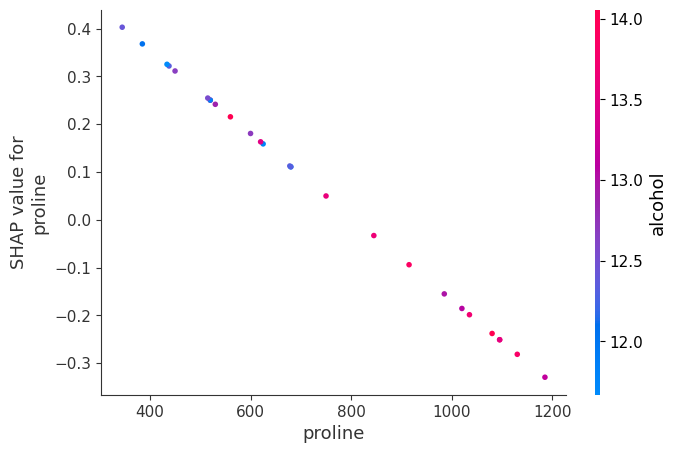

In [59]:
shap.dependence_plot("proline",
                     log_reg_explainer.shap_values(X_test)[0],
                     features=X_test,
                     feature_names=wine.feature_names,
                     )

shap.dependence_plot("proline",
                     log_reg_explainer.shap_values(X_test)[1],
                     features=X_test,
                     feature_names=wine.feature_names,
                     )

shap.dependence_plot("proline",
                     log_reg_explainer.shap_values(X_test)[2],
                     features=X_test,
                     feature_names=wine.feature_names,
                     )

__Below is the dependence plot with interaction value, interaction index is chosen automatically by shap__

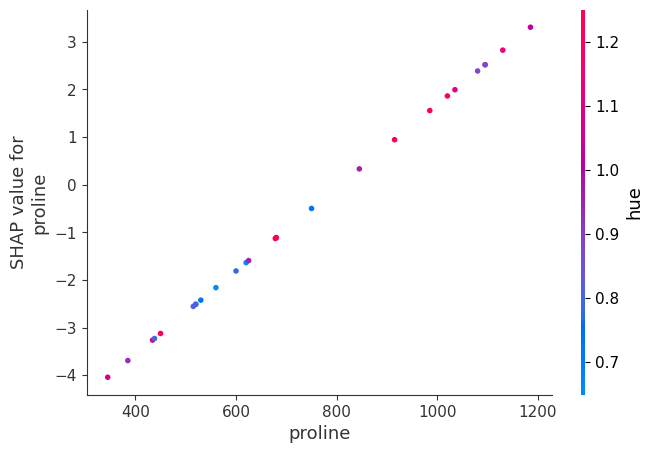

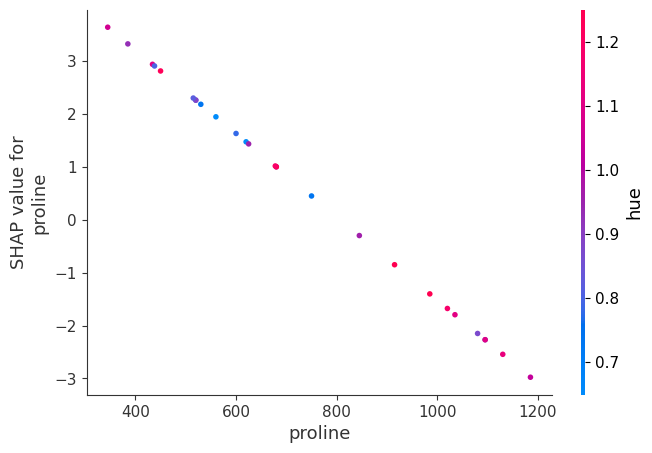

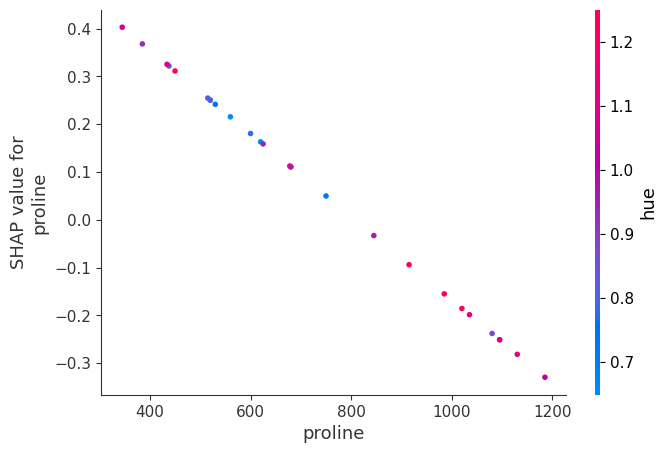

In [64]:
shap.dependence_plot("proline",
                     log_reg_explainer.shap_values(X_test)[0],
                     features=X_test,
                     feature_names=wine.feature_names, interaction_index='hue'
                     )

shap.dependence_plot("proline",
                     log_reg_explainer.shap_values(X_test)[1],
                     features=X_test,
                     feature_names=wine.feature_names,interaction_index='hue'
                     )

shap.dependence_plot("proline",
                     log_reg_explainer.shap_values(X_test)[2],
                     features=X_test,
                     feature_names=wine.feature_names,interaction_index='hue'
                     )

### Force Plot
The force plot shows shap values contributions in generating final prediction using an additive force layout. It shows which features contributed to how much positively or negatively to base value to generate a prediction.

We can generate force plot using force_plot() method. Below are list of important parameters for force_plot() method.

- expected_value - It accepts base value on which shap values will be added. The explainer object has a property named expected_value which needs to be passed to this parameter.
- shap_values - It accepts an array of shap values for an individual sample of data.
- feature_names - It accepts a list of feature names.
- out_names - It accepts string specifying target variable name.

__Below are the forceplots using explainer__

In [67]:
log_reg_explainer.expected_value

array([ 1.12479353, -0.33087671, -0.79391682])

In [65]:
shap.force_plot(log_reg_explainer.expected_value[0],
                log_reg_explainer.shap_values(X_test[0])[0],
                feature_names=wine.feature_names,
                out_names="Wine Type")

In [66]:
shap.force_plot(log_reg_explainer.expected_value[1],
                log_reg_explainer.shap_values(X_test[0])[1],
                feature_names=wine.feature_names,
                out_names="Wine Type")

In [68]:
shap.force_plot(log_reg_explainer.expected_value[2],
                log_reg_explainer.shap_values(X_test[0])[2],
                feature_names=wine.feature_names,
                out_names="Wine Type")

__Below is the forceplot for first 10 samples from the test dataset__
- x axis values are samples.
- y axis values are the predicted outputs for the samples

In [69]:
shap.force_plot(log_reg_explainer.expected_value[0],
                log_reg_explainer.shap_values(X_test[:10])[0],
                feature_names=wine.feature_names,
                out_names="Wine Type", figsize=(25,3),
                link="identity")

### Summary Plot
The summary plot shows the beeswarm plot showing shap values distribution for all features of data. We can also show the relationship between the shap values and the original values of all features.

We can generate summary plot using summary_plot() method. Below are list of important parameters of summary_plot() method.

- shap_values - It accepts array of shap values for individual sample of data.
- features - It accepts dataset which was used to generate shap values given to shap_values parameter.
- feature_names - It accepts list of feature names.
- max_display -It accepts integer specifying how many features to display in bar chart.
- plot_type - It accepts one of the below strings as input.
    - dot (default for single output)
    - bar - (default for multiple output)
    - violin
    
Below we have generated a summary plot of shap values generated from the test dataset using the first linear explainer. We can see a distribution of shap values and their relation with actual feature values based on the color bar on the right side.

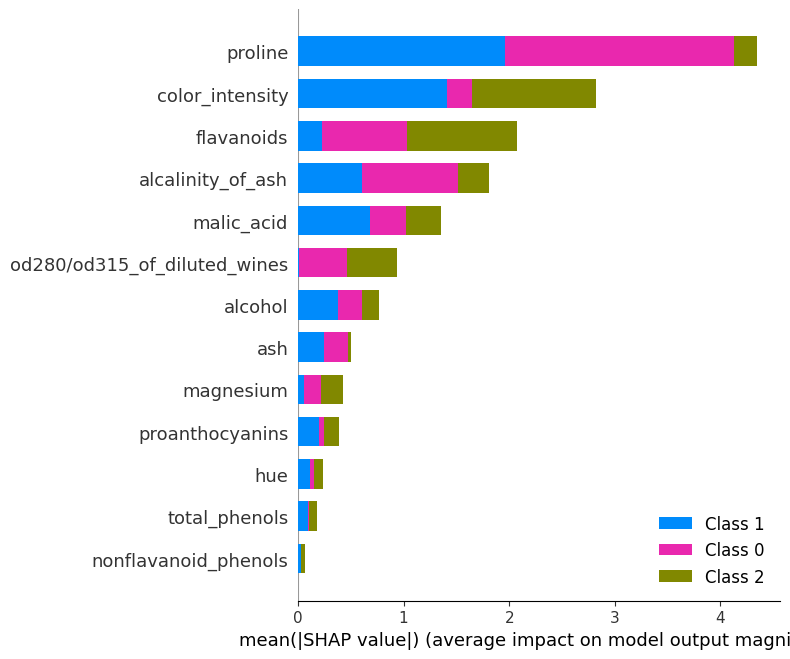

In [70]:
shap.summary_plot(log_reg_explainer.shap_values(X_test),
                  feature_names=wine.feature_names)

__Below is the summary plot generated for class1__

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


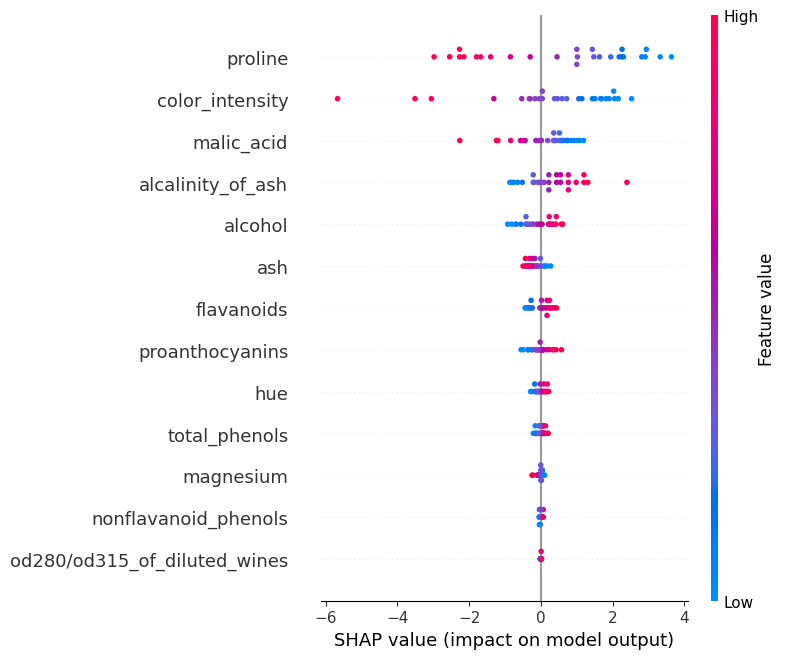

In [71]:
shap.summary_plot(log_reg_explainer.shap_values(X_test)[1],
                  features=X_test,
                  feature_names=wine.feature_names)

Below we have generated a summary plot with plot type as bar based on shape values generated from test data using the first linear explainer. The bar chart shows the average impact of each feature on the final prediction. This also highlights feature importance based on shap values.

### Partial Dependence Plot
The shap also provides us with a method named partial_dependence_plot() which can be used to generate a partial dependence plot. Below are list of important parameters of partial_dependence_plot() method.

- ind - It accepts either integer specifying the index of feature from data or string specifying the name of the feature. For future names given as a string, we need to provide feature names as a list to parameter feature_names.
- model - It expects a method that predicts the output of the model.
- data - It's data that will be used for generating the plot.
- feature_names - It accepts a list of feature names.

Below we have generated a partial dependence plot of the LSTAT feature based on test data.

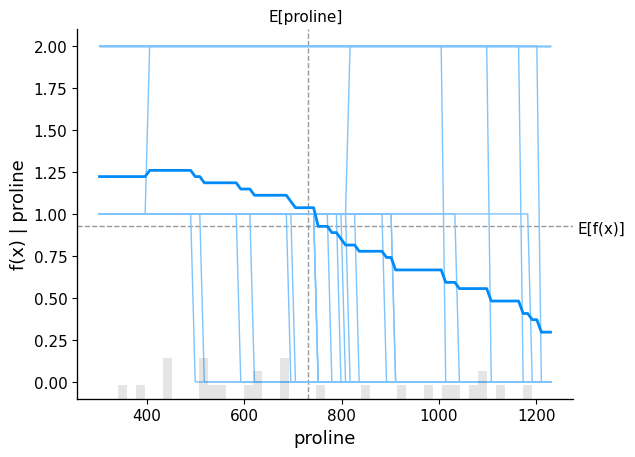

In [77]:
shap.partial_dependence_plot("proline",
                             log_reg.predict,
                             data=X_test,
                             feature_names=wine.feature_names,
                             model_expected_value=True,
                             feature_expected_value=True,
                             ice=True,
                             )

### Embedding Plot
The embedding plot projects shap values to 2D projection using PCA for visualization. This can help us see the spread of different shap values for a particular feature.

We can generate an embedding plot using the embedding_plot() method. Below is a list of important parameters of the embedding_plot() method.

- ind - It accepts either integer specifying the index of feature from data or string specifying the name of the feature. For future names given as a string, we need to provide feature names as a list to parameter feature_names.
- shap_values - It accepts an array of shap values for an individual sample of data.
- feature_names - It accepts a list of feature names.
- method - It accepts string pca or numpy array as input. If pca is given then use PCA to generate 2D projection. If a numpy array is given then its size should be (no_of_sample x 2) and will be considered embedding values.

Below we have generated an embedding plot for the CRIM feature on test data using our first linear explainer.

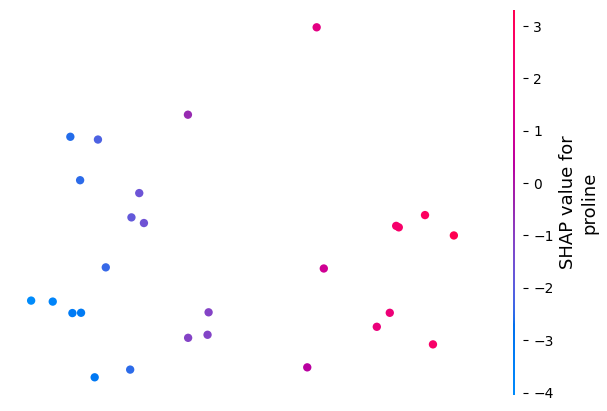

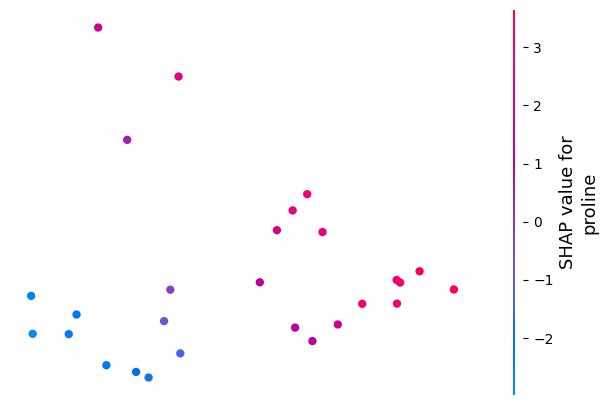

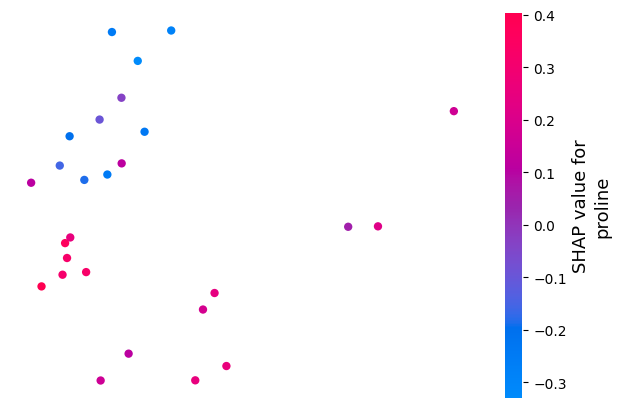

In [60]:
shap.embedding_plot("proline", log_reg_explainer.shap_values(X_test)[0], feature_names=wine.feature_names),
shap.embedding_plot("proline", log_reg_explainer.shap_values(X_test)[1], feature_names=wine.feature_names),
shap.embedding_plot("proline", log_reg_explainer.shap_values(X_test)[2], feature_names=wine.feature_names)